In [36]:
import pandas as pd
import numpy as np

# 머신러닝 도구
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 불균형 데이터를 위한 라이브러리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier

# 평가 지표
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# 경고 무시
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
# --- 데이터 로드
# df = pd.read_csv('./data/netflix_userdata_denoised.csv')
df = pd.read_csv('./data/netflix_feature_engineered.csv')

In [14]:
# --- 데이터 전처리

# 'Churn' 컬럼을 0(No)과 1(Yes)로 변환
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 모델링에 불필요한 컬럼 제거
# df = df.drop(['Customer ID'], axis=1)

# 결측치 처리
# 수치형 - 각 컬럼의 중위값 / 범주형 - 각 컬럼의 최빈값
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

In [15]:
df

,Subscription Length (Months),Customer Satisfaction Score (1-10),Daily Watch Time (Hours),Engagement Rate (1-10),Device Used Most Often,Region,Payment History (On-Time/Delayed),Subscription Plan,Support Queries Logged,Monthly Income ($),Promotional Offers Used,Number of Profiles Created,Churn,Age_group,User_Subscription_Price,Price_Burden_Ratio,Watch_Time_per_Dollar,Satisfaction_per_Dollar,Queries_per_Month
0,12.0,10.0,4.85,4.0,Tablet,Europe,On-Time,Basic,10.0,6250.0,5.0,2.0,1,30.0,9.544634,0.001527,0.508139,1.047709,0.833333
1,12.0,8.0,1.75,9.0,Laptop,Europe,On-Time,Basic,9.0,7018.0,1.0,5.0,1,20.0,9.544634,0.001360,0.183349,0.838167,0.750000
2,3.0,4.0,2.75,9.0,Smart TV,Asia,On-Time,Premium,3.0,1055.0,1.0,5.0,1,10.0,12.836000,0.012167,0.214241,0.311624,1.000000
3,3.0,7.0,3.00,9.0,Smart TV,Europe,On-Time,Premium,5.0,6707.0,5.0,4.0,1,30.0,19.483529,0.002905,0.153976,0.359278,1.666666
4,24.0,2.0,1.37,5.0,Mobile,North America,On-Time,Standard,2.0,1506.0,3.0,5.0,1,50.0,12.473659,0.008283,0.109831,0.160338,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119774,1.0,3.0,3.52,7.0,Laptop,Asia,Delayed,Basic,5.0,4022.0,0.0,1.0,1,40.0,6.500000,0.001616,0.541538,0.461538,4.999995
119775,6.0,6.0,3.54,1.0,Laptop,Europe,On-Time,Basic,9.0,4216.0,5.0,5.0,1,40.0,9.544634,0.002264,0.370889,0.628625,1.500000
119776,24.0,2.0,0.52,10.0,Desktop,North America,Delayed,Premium,3.0,8145.0,0.0,1.0,1,50.0,16.641220,0.002043,0.031248,0.120183,0.125000
119777,12.0,1.0,3.68,1.0,Laptop,Asia,Delayed,Basic,8.0,3664.0,3.0,2.0,1,20.0,6.500000,0.001774,0.566154,0.153846,0.666667


In [20]:
df.drop(['Device Used Most Often', 'Region', 'Payment History (On-Time/Delayed)', 'Number of Profiles Created'], axis=1, inplace=True)

In [16]:
# --- 데이터 분리
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [41]:
# --- 가중치 조정
# 가중치 배열 생성 -> 기본 가중치 1
sample_weights = np.ones(len(y_train))

# 가중치 부여 조건 설정(EDA 결과 기반)
# 조건 2: 고객 중 20~50대인 경우 가중치 2 부여
condition2 = (y_train == 0) & (X_train['Age_group'].isin(['50', '60', '70']))
sample_weights[condition2] = 2

# 조건 1. 이탈 고객 중 구독 기간이 6개월 이하인 경우 가중치 3 부여
condition1 = (y_train == 0) & (X_train['Subscription Length (Months)'] > 6)
sample_weights[condition1] = 3

# 조건 3: 소수 클래스 자체에 기본적으로 추가 가중치
condition3 = (y_train == 0)
sample_weights[condition3] = 9

In [ ]:
# --- 스케일링 및 인코딩
numerical_features = X.select_dtypes(include=np.number).columns.drop('Age_group').tolist() # Age_group은 전처리에서 제외
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [58]:
# 데이터 전처리 적용
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# 모델 정의 및 학습
model = LGBMClassifier()
model.fit(X_train_processed, y_train, sample_weight=sample_weights)

# 평가
# best_threshold, y_pred = predict_equal_precall(model, X_test_processed, y_test)
# best_threshold, y_pred = predict_equal_recall(model, X_test_processed, y_test)
best_threshold, y_pred = predict_equal_precision(model, X_test_processed, y_test)

print(f"최적 임계값: {best_threshold:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 74803, number of negative: 9042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 83845, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478951 -> initscore=-0.084247
[LightGBM] [Info] Start training from score -0.084247
최적 임계값: 0.08
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      3875
           1       0.89      1.00      0.94     32059

    accuracy                           0.89     35934
   macro avg       0.70      0.50      0.47     35934
weighted avg       0.85      0.89      0.84     35934



In [57]:
# --- 정밀도와 재현율이 같아지는 임계값 찾기
def predict_equal_precall(model, X_test, y_test):
    # predict_proba -> (Class 0, Class 1)
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 최적의 임계값 찾기 -> 정밀도와 재현율이 교차하는 지점의 인덱스
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    idx = np.argmin(np.abs(precisions - recalls))
    best_threshold = thresholds[idx]

    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 재현율이 같아지는 임계값 찾기
def predict_equal_recall(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    # 각 임계값에 대한 Recall을 저장할 리스트
    tnr_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        tnr = tn / (tn + fp)
        tnr_scores.append(tnr)

    diffs = np.abs(recalls[:-1] - tnr_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 정밀도가 같아지는 임계값 찾기
def predict_equal_precision(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    # 각 임계값에 대한 Precision을 저장할 리스트
    pre_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        pre = tn / (tn + fn) if (tn + fn) > 0 else 0
        pre_scores.append(pre)

    diffs = np.abs(precisions[:-1] - pre_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

In [39]:
# 정밀도 vs 재현율 시각화 모듈
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 6))

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_threshold:.2f}')
    
    plt.title('Precision-Recall vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')

    plt.grid()
    plt.legend()

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.show()

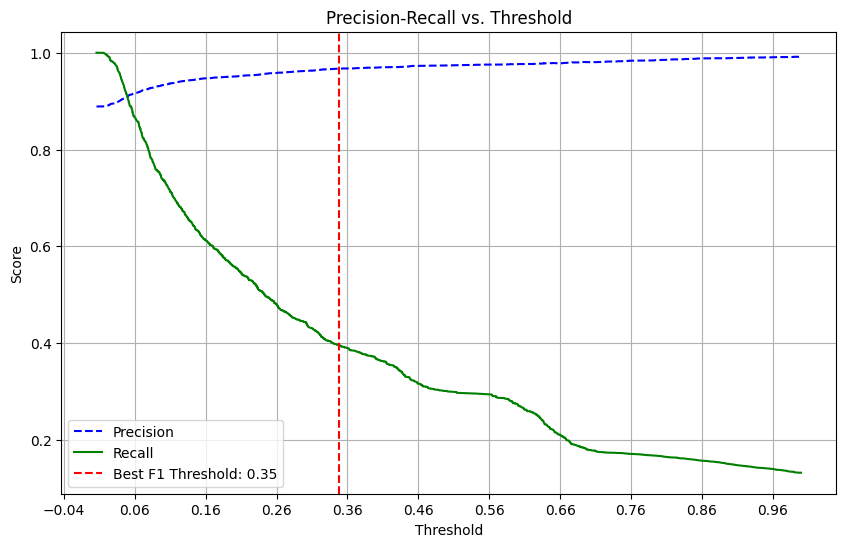

In [66]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier

df = pd.read_csv('./data/netflix_feature_engineered.csv')

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

drop_cols = ['Region', 'Device Used Most Often', 'Payment History (On-Time/Delayed)', 'Monthly Income ($)', 
             'Number of Profiles Created', 'Age_group', 'Support Queries Logged', 'Daily Watch Time (Hours)']
df.drop(columns=drop_cols, axis=1, inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = LGBMClassifier(random_state=42, class_weight='balanced')

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)
y_pred = (y_pred_proba[:, 1] > 0.7).astype(int)

print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 74803, number of negative: 74803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 149606, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.15      0.91      0.26      3875
           1       0.97      0.40      0.56     32059

    accuracy                           0.45     35934
   macro avg       0.56      0.65      0.41     35934
weighted avg       0.89      0.45      0.53     35934



c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


---
### 성능 지표 테이블 만들어보기

In [ ]:
# 성능 지표 테이블
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from lightgbm import LGBMClassifier

df = pd.read_csv('./data/netflix_feature_engineered.csv')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

model = LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_processed, y_train)

pred_proba = model.predict_proba(X_test_processed)[:, 1]

results = []
thresholds = np.linspace(0.05, 0.95, 20)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, pred_proba)
pr_auc = auc(recall_curve, precision_curve)

for thresh in thresholds:
    y_pred = (pred_proba >= thresh).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results.append({
        'Threshold': thresh,
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Macro_F1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, pred_proba), # ROC-AUC는 확률값으로 계산
        'PR_AUC': pr_auc,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
    })

df_results = pd.DataFrame(results[1:])

[LightGBM] [Info] Number of positive: 74803, number of negative: 9042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 83845, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Playdata\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
df_results[['Threshold', 'Macro_F1', 'ROC_AUC', 'PR_AUC', 'Precision_0', 'Recall_0', 'Precision_1', 'Recall_1']].round(4)

,Threshold,Macro_F1,ROC_AUC,PR_AUC,Precision_0,Recall_0,Precision_1,Recall_1
0,0.0974,0.4718,0.7653,0.963,0.3333,0.0003,0.8922,0.9999
1,0.1447,0.4750,0.7653,0.963,0.4000,0.0036,0.8924,0.9993
2,0.1921,0.5364,0.7653,0.963,0.3788,0.0810,0.8986,0.9839
3,0.2395,0.5766,0.7653,0.963,0.3294,0.1675,0.9050,0.9588
4,0.2868,0.6114,0.7653,0.963,0.2852,0.3569,0.9198,0.8919
5,0.3342,0.6044,0.7653,0.963,0.2543,0.4748,0.9291,0.8317
6,0.3816,0.5926,0.7653,0.963,0.2371,0.5812,0.9386,0.7740
7,0.4289,0.5762,0.7653,0.963,0.2233,0.6663,0.9469,0.7198
8,0.4763,0.5555,0.7653,0.963,0.2103,0.7396,0.9548,0.6643
9,0.5237,0.5350,0.7653,0.963,0.1992,0.7850,0.9597,0.6185


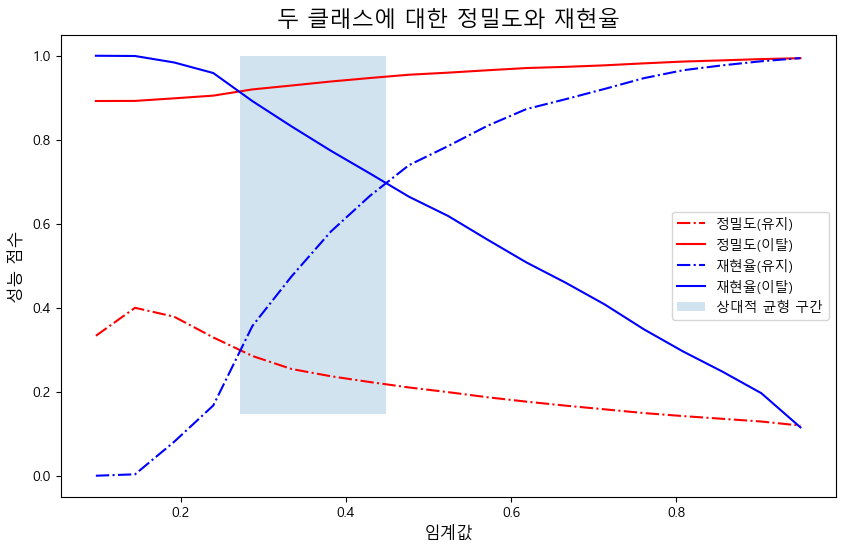

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

x = df_results['Threshold']

plt.figure(figsize=(10, 6))
plt.plot(x, df_results['Precision_0'], 'r-.', label='정밀도(유지)')
plt.plot(x, df_results['Precision_1'], 'r', label='정밀도(이탈)')
plt.plot(x, df_results['Recall_0'], 'b-.', label='재현율(유지)')
plt.plot(x, df_results['Recall_1'], 'b', label='재현율(이탈)')

# 최적 구간 찾아서 시각화
start = df_results['Threshold'][4] - 0.015
end = df_results['Threshold'][9] - 0.075
plt.fill_betweenx(y=df_results['Threshold']+0.05, x1=start, x2=end, alpha=0.2, label='상대적 균형 구간')
# plt.axvspan(start, end, color='gray', alpha=0.2, label='상대적 균형 구간')

plt.title('두 클래스에 대한 정밀도와 재현율', fontsize=16)
plt.xlabel('임계값', fontsize=12)
plt.ylabel('성능 점수', fontsize=12)

plt.legend()
plt.show()

---
### 딥러닝 시도

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# --- [추가된 부분 1] Keras 콜백 임포트 ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# 1. 데이터 로드 및 전처리 (이전과 동일)
df = pd.read_csv('./data/netflix_feature_engineered.csv')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features),('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

# 2. 딥러닝 모델 구축 및 컴파일 (이전과 동일)
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# --- [추가된 부분 2] 콜백 함수 정의 ---
# 조기 종료: 검증 손실(val_loss)이 5번 연속으로 개선되지 않으면 학습을 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 최적 모델 저장: 검증 손실이 가장 낮은 최고의 모델 가중치를 'best_model.h5' 파일로 저장
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 학습률 감소: 검증 손실이 3번 연속으로 개선되지 않으면 학습률을 50% 감소
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# 3. 모델 학습 시 콜백 적용
print("\n지능형 학습 기법(Callbacks)을 적용하여 딥러닝 모델 학습을 시작합니다...")
history = model.fit(
    X_train_processed,
    y_train,
    epochs=100, # 최대 epoch를 늘려주고, 조기 종료에 맡김
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    # --- [수정된 부분] fit 메서드에 callbacks 리스트 전달 ---
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1 # 학습 과정을 자세히 보기 위해 verbose 변경
)

model.load_weights('best_model.h5') # 가장 성능이 좋았던 시점의 가중치 로드

y_pred_proba = model.predict(X_test_processed)
y_pred = (y_pred_proba > 0.34).astype(int)

print(classification_report(y_test, y_pred))